In [2]:
import numpy as np                # import numpy
import matplotlib.pyplot as plt   # import matplotlib, a python 2d plotting libiary
from keras.datasets import mnist  # import the dataset
import tensorflow as tf           # import tensorflow
from keras.utils import np_utils  # import some other funstions
import cv2                        # a python computer vision libiary
from google.colab import drive    # in ordre to mount drive to colab
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [61]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


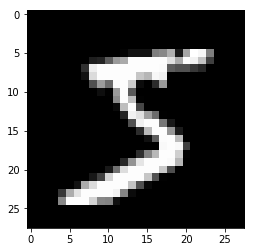

5


In [62]:
plt.imshow(x_train[0], cmap='gray')
plt.show()
print(y_train[0])

In [63]:
print(np.max(x_train[585]))
print(np.min(x_train[585]))

255
0


In [64]:
x_train = x_train/255.0
x_test = x_test/255.0

print("Shape before one-hot encoding: ", y_train.shape)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
print("Shape after one-hot encoding: ", y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [0]:
def neural_network(batch_digits):
  conv1 = tf.layers.conv2d(
      inputs=batch_digits,
      filters=128,
      kernel_size=[3,3],
      strides=(1,1),
      padding="same",
      activation=tf.nn.relu,
      name='conv1'
  )
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2, padding="same", name='pool1')

  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=128,
      kernel_size=[3,3],
      strides=(1,1),
      padding="same",
      activation=tf.nn.relu,
      name='conv2'
  )
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2, padding="same", name='pool2')
  pool2 = tf.reshape(pool2, [-1, 7 * 7 * 128])
  print(pool2)
  dense = tf.layers.dense(inputs=pool2, units=1024, activation=tf.nn.relu, name='dense')
  print(dense)
  dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=True, name='dropout')
  dense2 = tf.layers.dense(inputs=dropout, units=10, name='dense2')
  return tf.nn.softmax(dense2)


In [66]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


if __name__ == '__main__':
  sess = tf.Session()
  batch_size = 200
  LEARNING_RATE = 0.01
  num_epoch = 100
  start_epoch = 0
  width = 28

  own_digits_placeholder = tf.placeholder(dtype=tf.float32, shape=[1, width, width, 1], name='own_digits_placeholder')
  input_digits_placeholder = tf.placeholder(dtype=tf.float32, shape=[batch_size, width, width, 1], name='input_digits_placeholder')
  input_label_placeholder = tf.placeholder(dtype=tf.float32, shape=[batch_size, 10], name='input_label_placeholder')
  lr = tf.placeholder(dtype=tf.float32, shape=[])
  with tf.variable_scope('neural_network', reuse=tf.AUTO_REUSE) as scope_generator_model:
    prediction = neural_network(input_digits_placeholder)
    #loss = tf.nn.softmax_cross_entropy_with_logits(labels=input_label_placeholder, logits=prediction)
    loss = (input_label_placeholder - prediction)**2
    loss = tf.reduce_mean(loss)
    gen_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='neural_network')
    trainer = tf.train.FtrlOptimizer(learning_rate=lr).minimize(loss, var_list=gen_variables)
    own_pred = neural_network(own_digits_placeholder)       # feed your own written into the network.
                                                            # in tensorflow, we first build the network and then start training. When we built the network
                                                            # we define a placeholder since there is no actual value feed into the network for now
  
  saver = tf.train.Saver()
  #print("Begin training")
  print("Epoch;Learning Rate;Loss")
  sess.run(tf.global_variables_initializer())
  #saver.restore(sess, '/content/gdrive/My Drive/medical_imaging/model.ckpt')
  for iteration in range(start_epoch, num_epoch):
    #break
    num_batches = x_train.shape[0] // batch_size
    val_lr = LEARNING_RATE / (iteration + 1)
    #print("###################################")
    #print("epoch:{}".format(iteration))
    #print("learning rate:{}".format(val_lr))
    #print("num batch:{}".format(num_batches))
    #print("###################################")
    
    for i in range(num_batches):
      feed_batch_label = y_train[i * batch_size: (i + 1) * batch_size]
      feed_batch_digit = x_train[i * batch_size: (i + 1) * batch_size]
      feed_batch_digit = np.expand_dims(feed_batch_digit, -1)

      _, _loss = sess.run([trainer, loss], feed_dict={input_digits_placeholder:
                                                     feed_batch_digit,
                                                     input_label_placeholder:
                                                     feed_batch_label,
                                                     lr:val_lr})
    print("{};{};{}".format(iteration,val_lr,_loss))
    #print("Epoch:{} Loss:{}".format(iteration, _loss))
    saver.save(sess, '/content/gdrive/My Drive/medical_imaging/model.ckpt')

    for i in range(x_test.shape[0] // batch_size):
      #break
      test_image = x_test[i * batch_size: (i + 1) * batch_size]
      test_label = y_test[i * batch_size: (i + 1) * batch_size]
      feed_test_digit = np.expand_dims(test_image, -1)

      with tf.variable_scope('neural_network', reuse=tf.AUTO_REUSE) as scope_generator_model:
        estimated = sess.run(prediction, feed_dict={input_digits_placeholder:feed_test_digit})
      #print("-----------predicted digits-------------------")
      #print(np.argmax(estimated, 1))
      #print("-----------correct digit----------------------")
      #print(np.argmax(test_label, 1))
      #print("-----------accuracy---------------------------")
      correct_pred = np.equal(np.argmax(estimated,1), np.argmax(test_label, 1))
      accuracy = np.sum(correct_pred.astype(np.float32))
      #print(accuracy/batch_size)
      #print("-----------------------------------------------")
      #print("-----------------------------------------------")
      #print("----------------next testing batch-------------")
    
    continue
    real_digit = 3
    filename = '/content/gdrive/My Drive/bmed6590medical_imaging/own_' + str(real_digit) + '.png'
    own_digit = rgb2gray(plt.imread(filename))
    own_digit = own_digit / np.max(own_digit)
    #print(np.max(own_digit))
    #print(np.min(own_digit))
    own_digit = cv2.resize(own_digit, (width, width), interpolation=cv2.INTER_CUBIC)
    plt.imshow(own_digit, cmap='gray')
    plt.show()
    own_digit = np.expand_dims(own_digit, 0)    # expand one dimension at the beginning (28,28) to (1,28,28)
    own_digit = np.expand_dims(own_digit, -1)   # expand one dimension in the end (1,28,28) to (1,28,28,1)
    estimated = sess.run(own_pred, feed_dict={own_digits_placeholder: own_digit})
    #print("-----------predicted digits-------------------")
    #print(np.argmax(estimated, 1))
    #print("-----------correct digit----------------------")
    #print(real_digit)
  

Tensor("neural_network_10009/Reshape:0", shape=(200, 6272), dtype=float32)
Tensor("neural_network_10009/dense/Relu:0", shape=(200, 1024), dtype=float32)
Tensor("neural_network_10009/Reshape_1:0", shape=(1, 6272), dtype=float32)
Tensor("neural_network_10009/dense_1/Relu:0", shape=(1, 1024), dtype=float32)
Epoch;Learning Rate;Loss
0;0.01;0.08999963104724884
1;0.005;0.08999963104724884
2;0.0033333333333333335;0.08999963104724884
3;0.0025;0.08999963104724884
4;0.002;0.08999962359666824
5;0.0016666666666666668;0.08999962359666824
6;0.0014285714285714286;0.08999962359666824
7;0.00125;0.08999962359666824
8;0.0011111111111111111;0.08999962359666824
9;0.001;0.08999963104724884
10;0.0009090909090909091;0.08999963104724884
11;0.0008333333333333334;0.08999963104724884
12;0.0007692307692307692;0.08999962359666824
13;0.0007142857142857143;0.08999963104724884
14;0.0006666666666666666;0.08999962359666824
15;0.000625;0.08999962359666824
16;0.0005882352941176471;0.08999962359666824
17;0.0005555555555555